# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
!pip install wheel==0.38.4
!pip install setuptools==66
!pip install gym==0.21.0

import os

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [4]:
policy = np.full([n_states,n_actions], 1/n_actions)
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [5]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])
        
        new_s,r,done,info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        #add state
        #add action
        #add reward
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [6]:
help(env.step)

Help on method step in module gym.wrappers.time_limit:

step(action) method of gym.wrappers.time_limit.TimeLimit instance
    Run one timestep of the environment's dynamics. When end of
    episode is reached, you are responsible for calling `reset()`
    to reset this environment's state.
    
    Accepts an action and returns a tuple (observation, reward, done, info).
    
    Args:
        action (object): an action provided by the agent
    
    Returns:
        observation (object): agent's observation of the current environment
        reward (float) : amount of reward returned after previous action
        done (bool): whether the episode has ended, in which case further step() calls will return undefined results
        info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)



In [7]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,float]

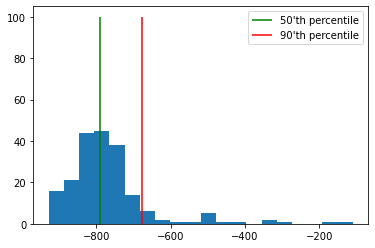

In [8]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [9]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile) #recalc threshold. hint : np.percentile
    
    elite_states = []
    
    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(np.compress((rewards_batch >= reward_threshold), states_batch))
    else:
        elite_states = np.vstack(np.compress((rewards_batch >= reward_threshold), states_batch))
    elite_actions = np.hstack(np.compress((rewards_batch >= reward_threshold), actions_batch))
    
    return elite_states,elite_actions
    

In [10]:
states_batch = np.array([
    np.array([1,2,3], dtype=float),   #game1
    np.array([4,2,0,2], dtype=float), #game2
    np.array([3,1], dtype=float)      #game3
])

actions_batch = np.array([
    np.array([0,2,4], dtype=float),   #game1
    np.array([3,2,0,1], dtype=float), #game2
    np.array([3,3], dtype=float)      #game3
])
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
], dtype=float)

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=40)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


C:\Users\slivantus2007\AppData\Local\Temp\ipykernel_35248\4008565842.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states_batch = np.array([
C:\Users\slivantus2007\AppData\Local\Temp\ipykernel_35248\4008565842.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions_batch = np.array([


In [11]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    elite_states = np.array(elite_states)
    elite_actions = np.array(elite_actions)
    
    np.add.at(new_policy, (elite_states, elite_actions), 1)
    sums = np.sum(new_policy, axis=1)
    
    sums = np.repeat(sums, n_actions)
    sums[sums == 0] = 1
    sums = np.reshape(sums, (n_states, n_actions))
    new_policy /= sums
    
    sums = np.sum(new_policy, axis=1)
    new_policy[sums < 1e-9] = np.full(n_actions, 1/n_actions)
    
    #<Your code here: update probabilities for actions given elite states & actions>
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    
    return new_policy

In [12]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [14]:
#reset policy just in case
policy = np.full((n_states, n_actions), 1/n_actions)

mean reward = -46.684, threshold=7.000


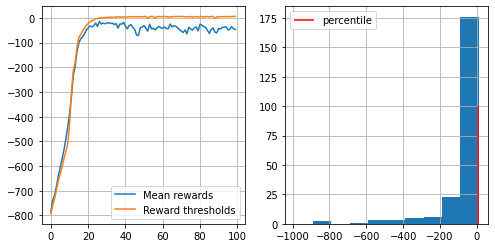

In [15]:
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate*new_policy+(1-learning_rate)*policy
    
    #display results on chart
    show_progress(rewards_batch,log)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [16]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,float]
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 100

# How do different percentiles affect training efficiency?

In [17]:
def show_for_multiple(axis_name, cur, rewards_batch, perc, reward_range=[-990,+10]):
    #print(cur)
    #print(logs)
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,perc)
    if len(logs)-1 < cur:
        logs.append([[], []])
        axis_names.append(axis_name)
    logs[-1][0].append(mean_reward)
    logs[-1][1].append(threshold)
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[16,12])

    for i in range(cur+1):
        #pass
        plt.plot(logs[i][0], label = axis_names[i][0])
        plt.plot(logs[i][1], label = axis_names[i][1])
        #print([el[0] for el in logs[cur]])
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
import matplotlib.colors as mcolors
from cycler import cycler
cols = list(mcolors.TABLEAU_COLORS.keys())
plt.rc('axes', prop_cycle=(cycler('color', cols)))

mean reward = -731.428, threshold=13.000


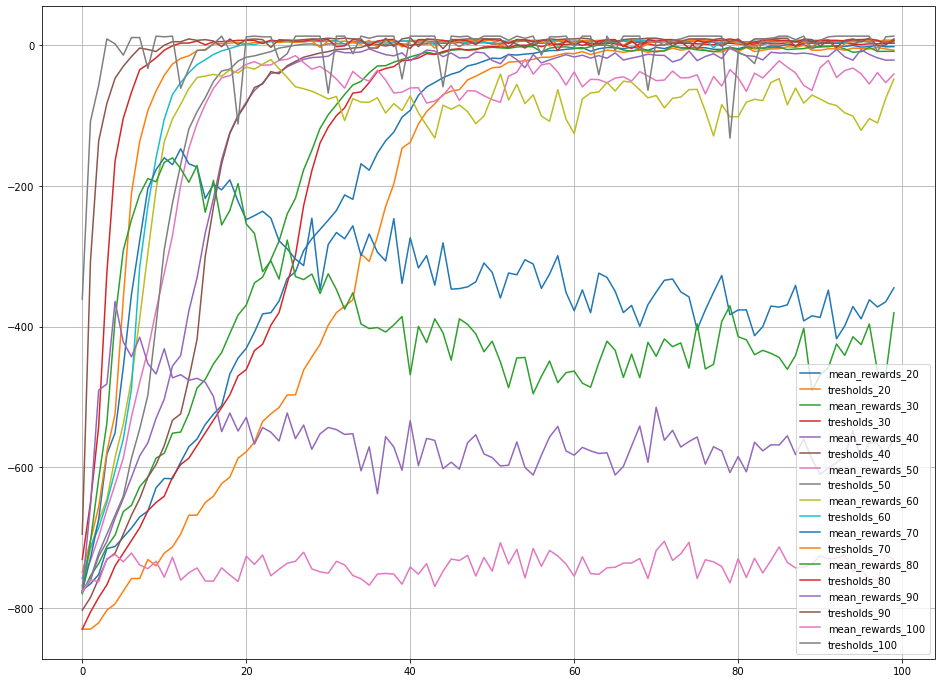

In [19]:
logs = []
axis_names = []

n_sessions = 250  #sample this many sessions
percentiles = list(range(20, 101, 10))  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability
#n_sessions = 10
idx = 0
for perc in percentiles:
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):
        sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=perc)
        
        new_policy = update_policy(elite_states,elite_actions)
        policy = learning_rate*new_policy+(1-learning_rate)*policy
        show_for_multiple((f"mean_rewards_{perc}", f"tresholds_{perc}"), idx, rewards_batch, perc)
    idx += 1

Make a graph with several training runs with different hyperparemeters

mean reward = -7.892, threshold=6.000


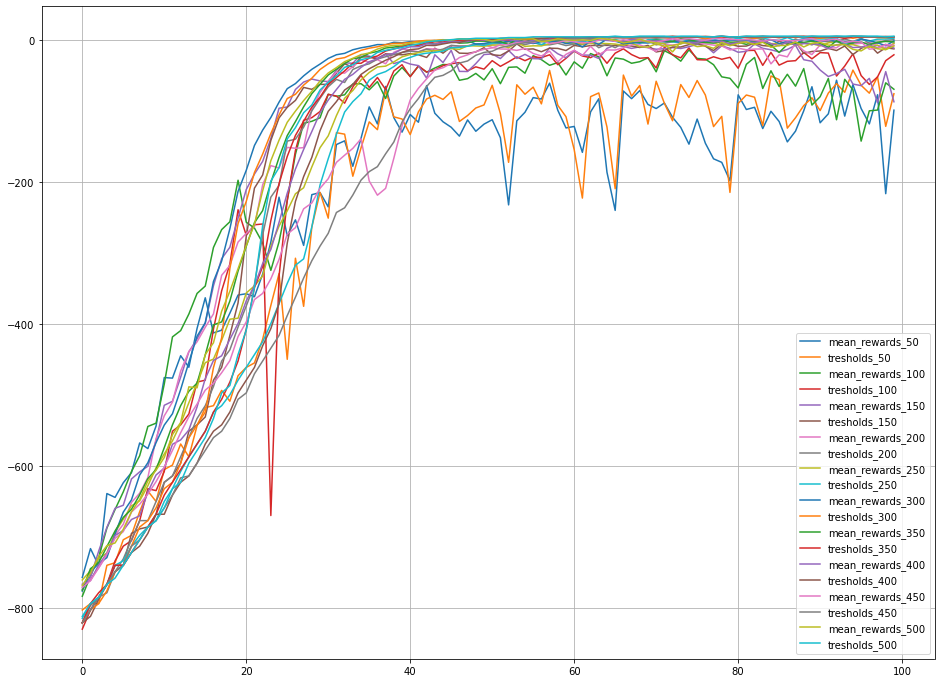

In [20]:
logs = []
axis_names = []

n_sessions_ar = list(range(50, 501, 50))  #sample this many sessions
perc = 30  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability
#n_sessions = 10
idx = 0
for n_sessions in n_sessions_ar:
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):
        sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=perc)
        
        new_policy = update_policy(elite_states,elite_actions)
        policy = learning_rate*new_policy+(1-learning_rate)*policy
        show_for_multiple((f"mean_rewards_{n_sessions}", f"tresholds_{n_sessions}"), idx, rewards_batch, perc)
    idx += 1

# Stabilize positive rewards by averaging policy across 10 games (4 pts)

In [151]:
n_sessions = 400  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
policies = []
for _ in range(10):
    print(_)
    for i in range(150):
        sessions = [generate_session(policy) for _ in range(n_sessions)]
    
        states_batch,actions_batch,rewards_batch = zip(*sessions)
    
        elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=50)
    
        new_policy = update_policy(elite_states,elite_actions)
        policy = learning_rate*new_policy+(1-learning_rate)*policy
    
        #show_progress(rewards_batch,log)
        
        if(np.mean(rewards_batch) > 7):
            print("win!")
            break
    policies.append(policy)


0


C:\Users\slivantus2007\AppData\Local\Temp\ipykernel_35248\609711554.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=50)


1
2
3
4
5
6
7
8
9


In [152]:
policies = np.array(policies)

In [153]:
avg_policy = np.zeros([n_states,n_actions])
for el in policies:
    avg_policy += el
avg_policy /= 10
avg_policy

array([[1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01],
       [2.81165248e-13, 5.72403434e-04, 1.22890139e-10, 8.45113971e-07,
        9.99426751e-01, 2.57912462e-13],
       [1.11160217e-08, 9.16267992e-04, 5.69095041e-11, 3.81376618e-03,
        9.95269955e-01, 6.50850069e-13],
       ...,
       [1.50000003e-01, 2.49998923e-01, 1.50001074e-01, 1.50000000e-01,
        1.50000000e-01, 1.50000000e-01],
       [1.66666608e-01, 1.66666615e-01, 1.66666632e-01, 1.66666928e-01,
        1.66666608e-01, 1.66666608e-01],
       [1.05392384e-01, 1.02832384e-01, 1.05407010e-01, 4.80703454e-01,
        1.02832384e-01, 1.02832384e-01]])

In [161]:
sessions = [generate_session(avg_policy) for _ in range(n_sessions)]
states_batch, actions_batch, rewards_batch = zip(*sessions)
mean_reward = np.mean(rewards_batch)
threshold = np.percentile(rewards_batch,percentile)

print(mean_reward, threshold)

-43.9875 9.0
